In [7]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark import SparkContext

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

SparkContext.setSystemProperty('spark.executor.memory', '2g')

In [8]:
inputFile = "sampleData/uber-raw-data-apr14.csv"

uberRDD = sc.textFile(inputFile).filter(lambda line: "Date" not in line)

In [9]:
# cleaning and pre-processing Uber Data
# converting to base, long, lat, hour(0-23), day, month, year

def formatData(line):
    lines = line.strip().split(",")
    dateTime = lines[0].strip('"').split()
    date = dateTime[0]
    time = dateTime[1]
    month = date.strip().split("/")[0]
    day = date.strip().split("/")[1]
    year = date.strip().split("/")[2]    
    hour = time.strip().split(":")[0]
    # dividing NYC into blocks of approx. 1x1 KM (1 degree ~ 110 km)
    long = float("{0:.2f}".format(float(lines[1]))) 
    lat = float("{0:.2f}".format(float(lines[2])))
    base = lines[3].strip('"')
    tup = (long, lat, base, int(hour), int(day), int(month), int(year))
    return tup

In [10]:
uberPD = uberRDD.map(lambda line: formatData(line))\
                         .toDF(['longitude', 'latitude', 'base', 'hour', 'day', 'month', 'year'])\
                         .toPandas()
uberPD.info()
uberPD.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 7 columns):
longitude    564516 non-null float64
latitude     564516 non-null float64
base         564516 non-null object
hour         564516 non-null int64
day          564516 non-null int64
month        564516 non-null int64
year         564516 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 30.1+ MB


,longitude,latitude,base,hour,day,month,year
0,40.77,-73.95,B02512,0,1,4,2014
1,40.73,-74.03,B02512,0,1,4,2014
2,40.73,-73.99,B02512,0,1,4,2014
3,40.76,-73.98,B02512,0,1,4,2014
4,40.76,-73.97,B02512,0,1,4,2014


In [11]:
UberPD = uberPD.groupby(['longitude', 'latitude', 'base', 'hour', 'day', 'month', 'year'])['longitude'].count().reset_index(name='demand')
UberPD['demand'].sum()

564516

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime

cal = calendar()
dateRange = pd.date_range(start='2014-04-01', end='2014-04-30')
holidays = cal.holidays(start=dateRange.min(), end=dateRange.max())

# returns 1 if US holiday else 0
def isHoliday(row):
    date = datetime.datetime(row['year'], row['month'], row['day'])
    return 1 if date in holidays else 0

UberPD['isHoliday'] = UberPD.apply(lambda row: isHoliday(row), axis=1)

In [27]:
# returns weekdays (1-7)
def getWeekDay(row):
    weekday = datetime.datetime(row['year'], row['month'], row['day']).isoweekday()
    return weekday

UberPD['weekDay'] = UberPD.apply(lambda row: getWeekDay(row), axis=1)

In [28]:
# cleaning and pre-processing Weather Data

def formatWeatherData(line):
    lines = line.strip().split(",")
    if(len(lines) == 31):
        date = lines[2]
        month = date[4:6].lstrip('0')
        day = date[6:].lstrip('0')
        year = date[0:4].lstrip('0')
        PRCP = lines[3]
        SNWD = lines[4]
        SNOW = lines[5]
        print(lines[6])
        print(lines[7])
        TMAX = int(lines[6]) if not lines[6].strip().isspace() else -9999
        TMIN = int(lines[7]) if not lines[6].strip().isspace() else -9999
        AVGTEMP = float((TMIN + TMAX)/2)
        weatherTuple = (int(day), int(month), int(year), PRCP, SNWD, SNOW, TMAX, TMIN, AVGTEMP)
        return weatherTuple

In [29]:
weatherPD = sc.textFile("sampleData/weatherNYC")\
                .filter(lambda line: "STATION" not in line)\
                .map(lambda line: formatWeatherData(line))\
                .toDF(['day', 'month', 'year', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AVGTEMP'])\
                .toPandas()
weatherPD.info()
weatherPD.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
day        30 non-null int64
month      30 non-null int64
year       30 non-null int64
PRCP       30 non-null object
SNWD       30 non-null object
SNOW       30 non-null object
TMAX       30 non-null int64
TMIN       30 non-null int64
AVGTEMP    30 non-null float64
dtypes: float64(1), int64(5), object(3)
memory usage: 2.2+ KB


,day,month,year,PRCP,SNWD,SNOW,TMAX,TMIN,AVGTEMP
0,1,4,2014,0,0,0,156,39,97.5
1,2,4,2014,0,0,0,122,56,89.0
2,3,4,2014,18,0,0,194,78,136.0
3,4,4,2014,53,0,0,83,44,63.5
4,5,4,2014,0,0,0,122,44,83.0


In [30]:
UberWeatherPD = pd.merge(UberPD, weatherPD, how='left', on=['day','month','year'])
UberWeatherPD.info()
UberWeatherPD.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170187 entries, 0 to 170186
Data columns (total 16 columns):
longitude    170187 non-null float64
latitude     170187 non-null float64
base         170187 non-null object
hour         170187 non-null int64
day          170187 non-null int64
month        170187 non-null int64
year         170187 non-null int64
demand       170187 non-null int64
isHoliday    170187 non-null int64
weekDay      170187 non-null int64
PRCP         170187 non-null object
SNWD         170187 non-null object
SNOW         170187 non-null object
TMAX         170187 non-null int64
TMIN         170187 non-null int64
AVGTEMP      170187 non-null float64
dtypes: float64(3), int64(9), object(4)
memory usage: 22.1+ MB


,longitude,latitude,base,hour,day,month,year,demand,isHoliday,weekDay,PRCP,SNWD,SNOW,TMAX,TMIN,AVGTEMP
0,40.07,-74.16,B02617,14,8,4,2014,1,0,2,86,0,0,178,78,128.0
1,40.19,-74.60,B02682,10,7,4,2014,1,0,1,132,0,0,117,61,89.0
2,40.20,-74.12,B02682,16,23,4,2014,1,0,3,0,0,0,161,67,114.0
3,40.22,-74.57,B02617,18,14,4,2014,1,0,1,0,0,0,239,150,194.5
4,40.23,-74.62,B02598,21,2,4,2014,1,0,3,0,0,0,122,56,89.0


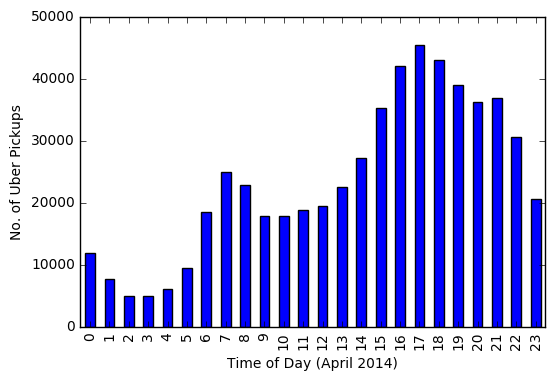

In [17]:
hourDemand = UberWeatherPD['demand'].groupby(UberWeatherPD['hour']).sum()
hourDemand.plot(kind='bar')
plt.xlabel("Time of Day (April 2014)")
plt.ylabel("No. of Uber Pickups")

In [18]:
print("Maximum demand was", hourDemand.max() , "in the hour", hourDemand.idxmax())
print("Minimum demand was", hourDemand.min() , "int the hour",  hourDemand.idxmin())

Maximum demand was 45475 in the hour 17
Minimum demand was 4935 int the hour 2


In [19]:
print("Mean Demand for month of April 2014: ", hourDemand.mean())
print("Total Demand for month of April 2014: ", hourDemand.sum())

Mean Demand for month of April 2014:  23521.5
Total Demand for month of April 2014:  564516


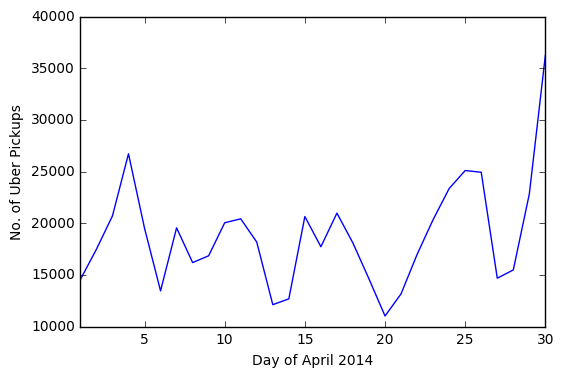

In [20]:
dayDemand = UberWeatherPD['demand'].groupby(UberWeatherPD['day']).sum()
dayDemand.plot(kind='line')
plt.xlabel("Day of April 2014")
plt.ylabel("No. of Uber Pickups")

In [21]:
print("Maximum demand was", dayDemand.max() , "on the day", dayDemand.idxmax())
print("Minimum demand was", dayDemand.min() , "on the day", dayDemand.idxmin())

Maximum demand was 36251 on the day 30
Minimum demand was 11017 on the day 20


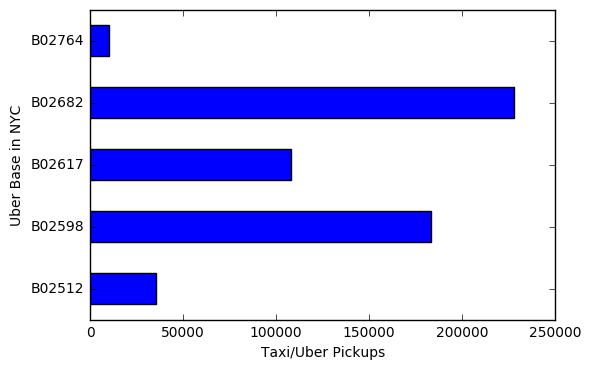

In [22]:
baseDemand = UberWeatherPD['demand'].groupby(UberWeatherPD['base']).sum()
baseDemand.plot(kind='barh')
plt.xlabel('Taxi/Uber Pickups')
plt.ylabel('Uber Base in NYC')

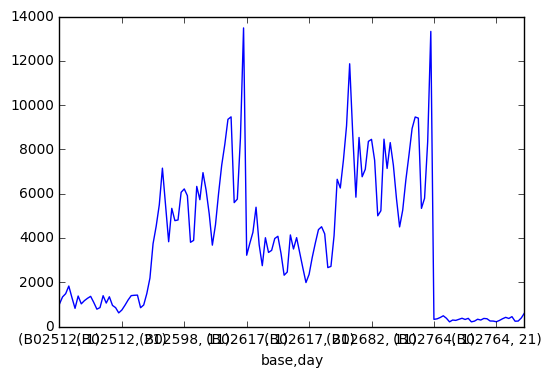

In [23]:
dayBaseDemand = UberWeatherPD['demand'].groupby([UberWeatherPD['base'], UberWeatherPD['day']]).sum()
dayBaseDemand.head()
dayBaseDemand.plot(kind='line')

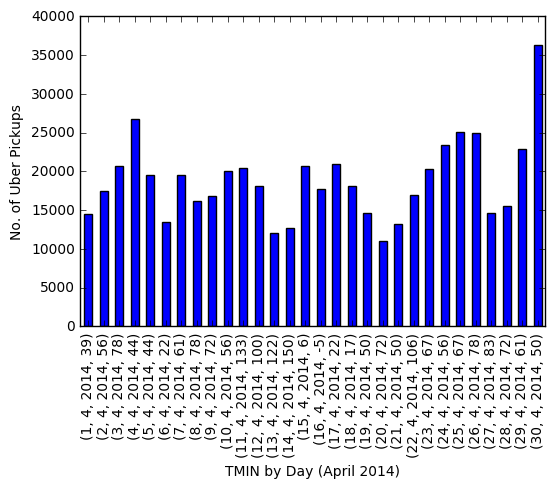

In [24]:
tempDemand = UberWeatherPD['demand'].groupby([UberWeatherPD['day'],UberWeatherPD['month'],UberWeatherPD['year'],UberWeatherPD['TMIN']]).sum()
tempDemand.plot(kind='bar')
plt.xlabel("TMIN by Day (April 2014)")
plt.ylabel("No. of Uber Pickups")

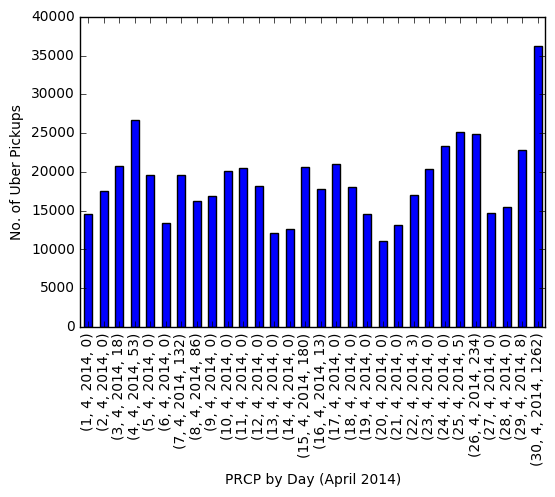

In [25]:
rainDemand = UberWeatherPD['demand'].groupby([UberWeatherPD['day'],UberWeatherPD['month'],UberWeatherPD['year'],UberWeatherPD['PRCP']]).sum()
rainDemand.plot(kind='bar')
plt.xlabel("PRCP by Day (April 2014)")
plt.ylabel("No. of Uber Pickups")

April 30, 2014 => A significant rain event continues to affect the area with a line of heavy rain training over New Jersey, with rain totals over 2-3 inches for most locations west of NYC.

Comparing same days of week:<br>
04/08/2014 | prcp = 86 | demand = 17k<br>
04/15/2014 | prcp = 180 | demand = 22k<br>
04/22/2014 | prcp = 3 | demand = 16k<br>

This proves that rain (precipitation) has effect on demand

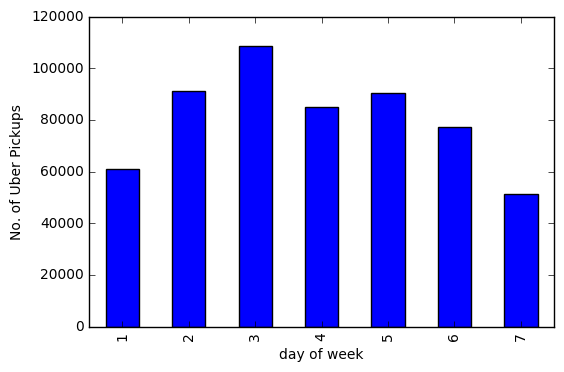

In [31]:
weekDayDemand = UberWeatherPD['demand'].groupby(UberWeatherPD['weekDay']).sum()
weekDayDemand.plot(kind='bar')
plt.xlabel("day of week")
plt.ylabel("No. of Uber Pickups")